# Car prices prediction

## Intro

Our customer is a used car sales service that develops an application to attract new clients. The app helps to determine the market price of the user's car.

The following criteria are essential for the customer:
* prediction quality
* time required for model training
* time required for prediction

**Objective** is to train a model with RMSE score under 2500

### Additional conditions
* use `LightBGM` library for gradient boosting
* use at least one non-GB model
* determine evaluation time for JupyterNB cells

### Dataset description

Dataset objects are entries crawled from car profile forms:

* `DateCrawled` — date the form was downloaded on from a database
* `VehicleType` — car body type
* `RegistrationYear` — year of car registration
* `Gearbox` — gearbox type
* `Power` — horsepower (hp)
* `Model` — car model
* `Kilometer` — car mileage (km)
* `RegistrationMonth` — month of car registration
* `FuelType` — fuel type
* `Brand` — car brand
* `Repaired` — was the car in repair or not
* `DateCreated` — car profile creation date
* `NumberOfPictures` — number of car photos
* `PostalCode` — postal code of a user who owns a car profile
* `LastSeen` — last user activity date

Target feature:
* `Price` — price (euro)

## Imports

In [1]:
from os import path
from time import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ydata_profiling import ProfileReport
from scipy.stats import percentileofscore, iqr

In [2]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.dummy import DummyRegressor

from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor

from optuna.integration import OptunaSearchCV
from optuna.distributions import IntDistribution, FloatDistribution, CategoricalDistribution

We will use `ydata-profiling` library for EDA: https://github.com/ydataai/ydata-profiling.

### Globals

In [3]:
PATH_TO_LOCAL_DATA = './datasets/autos.csv'  # path to local dataset
PATH_TO_CLOUD_DATA = '/datasets/autos.csv' # path to dataset on server
RND = 1337  # randon state

## Custom classes and functions

### Class: `BoxplotStats`

In [4]:
# determine statistics from boxplot

class BoxplotStats():
    """
    data: this must be a pandas.Series or similar type
    import pandas
    from scipy.stats import iqr
    """
    def __init__(self, data):
        self.q25, self.q75 = data.quantile(0.25), data.quantile(0.75)
        iqr_value = iqr(data)
        self.lower_fence, self.upper_fence = self.q25 - 1.5 * iqr_value, self.q75 + 1.5 * iqr_value
    
    def report(self):
        """
        Returns small report about boxplot values
        """
        print("Boxplot values")
        print("Q1:", self.q25)
        print("Q3:", self.q75)
        print("Lower fence:", self.lower_fence)
        print("Upper fence", self.upper_fence)

### Function: `d_print`

In [5]:
# prints a dictionary

def d_print(dictionary):
    for k, v in dictionary.items():
        print(f"{k}: {v}")

I have one more custom class, it is determined in the modeling secion

## Open data and EDA

In [6]:
date_columns=['DateCrawled', 'DateCreated', 'LastSeen']

In [7]:
if path.exists(PATH_TO_LOCAL_DATA):
    df = pd.read_csv(PATH_TO_LOCAL_DATA, parse_dates=date_columns)
    PATH_TO_PROCESSED_DATA = './datasets/autos_processed.csv'  # path to data after cleaning
    print('Loaded from the local storage.\n')
elif path.exists(PATH_TO_CLOUD_DATA):
    df = pd.read_csv(PATH_TO_CLOUD_DATA, parse_dates=date_columns)
    PATH_TO_PROCESSED_DATA = '/datasets/autos_processed.csv'  # path to data after cleaning
    print('Loaded from the remote storage.\n')
else:
    raise ValueError('Unable to load data. Check paths to files.')

display(df.head(3), df.info())

Loaded from the local storage.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPict

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46


None

We will profile data using `ProfileReport` object

In [8]:
# ydata_profiling
profile = ProfileReport(df, title="Autos")

In [9]:
# widget for of a report
# takes less space, easier to navigate,
# but has to be rendered every time you open notebook
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

Let's check the alerts the report provided us with

### Data problems

The profiler provides us with the following alerts:

* `NumberOfPictures` has constant value ""	
* `Dataset` has 4 (< 0.1%) duplicate rows	
* `Model` has a high cardinality: 250 distinct values	 
* `Price` is highly overall correlated with `RegistrationYear` and 1 other fields	 
* `RegistrationYear` is highly overall correlated with `Price` and 1 other fields	 
* `Power` is highly overall correlated with `Price`	 
* `VehicleType` is highly overall correlated with `RegistrationYear`	 
* `FuelType` is highly imbalanced (63.0%)	
* `VehicleType` has 37490 (10.6%) missing values	
* `Gearbox` has 19833 (5.6%) missing values	
* `Model` has 19705 (5.6%) missing values	
* `FuelType` has 32895 (9.3%) missing values	
* `Repaired` has 71154 (20.1%) missing values	
* `RegistrationYear` is highly skewed (γ1 = 74.62100514)	
* `Power` is highly skewed (γ1 = 60.15719573)	
* `Price` has 10772 (3.0%) zeros	
* `Power` has 40225 (11.4%) zeros	
* `RegistrationMonth` has 37352 (10.5%) zeros	

### Data preparation

#### Zeros


As the report says there are zeroes in `Price`, `Power` and `RegistrationMonth` columns. We will remove entries with `Price == 0` since thats our target data. Luckily, it's only 3% of data.

Also the distribution of `Price` shows there are many low values, with 5th percentile equal to **200** and **500** being one of the most common values after **0**.

In [10]:
# top 10 most popular Price values
df['Price'].value_counts().sort_values(ascending=False).head(10)

0       10772
500      5670
1500     5394
1000     4649
1200     4594
2500     4438
600      3819
3500     3792
800      3784
2000     3431
Name: Price, dtype: int64

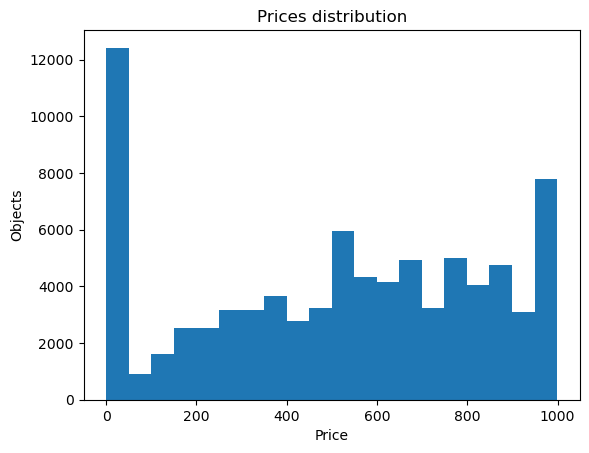

In [11]:
%matplotlib inline
# top 10 most popular Price values
df.query('Price < 1000')['Price'].plot(kind='hist', bins=20, title='Prices distribution')
plt.xlabel('Price')
plt.ylabel('Number of objects')
plt.show()

We will remove entries with `Price` lower than **500**. This will remove **~10%** of dataset

In [12]:
percentileofscore(df['Price'], 499)

10.079606286102905

In [13]:
# removing low Price
df = df[df['Price'] >= 500].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318315 entries, 1 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        318315 non-null  datetime64[ns]
 1   Price              318315 non-null  int64         
 2   VehicleType        291221 non-null  object        
 3   RegistrationYear   318315 non-null  int64         
 4   Gearbox            304962 non-null  object        
 5   Power              318315 non-null  int64         
 6   Model              303634 non-null  object        
 7   Kilometer          318315 non-null  int64         
 8   RegistrationMonth  318315 non-null  int64         
 9   FuelType           294997 non-null  object        
 10  Brand              318315 non-null  object        
 11  Repaired           263719 non-null  object        
 12  DateCreated        318315 non-null  datetime64[ns]
 13  NumberOfPictures   318315 non-null  int64   

`RegistrationMonth` column has zero values too, which is not good

In [14]:
# checking values for RegistrationMonth
df['RegistrationMonth'].value_counts().sort_index()

0     24815
1     21130
2     19475
3     31835
4     26936
5     26874
6     29144
7     25277
8     21011
9     22252
10    24412
11    22650
12    22504
Name: RegistrationMonth, dtype: int64

This **0** value might mean data on registration month was not provided. There are two options how to deal with it:
* Change **0** to **NaN** value to show data was not provided
* Remove the entire column from train data since this feature intuivly has less connection with `Price` than `RegistrationYear`
I will choose the second option for now. If metrics are bad I will bring it back.

In [15]:
# removing RegistrationMonth column
df = df.drop(columns = ['RegistrationMonth'])
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'FuelType', 'Brand', 'Repaired',
       'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'],
      dtype='object')

Column `Power` has zeroes, this data is vital for target data and shows high correlation too. We have 2 options how to deal with this:
* Assume `Power == 0` means data was not provided and change **0** to **NaN** for `Power`
* Remove all entries with zero values in `Power`

In [16]:
df.query('Power == 0').shape[0] / df.shape[0]

0.09004602359298179

In [17]:
import matplotlib.pyplot as plt

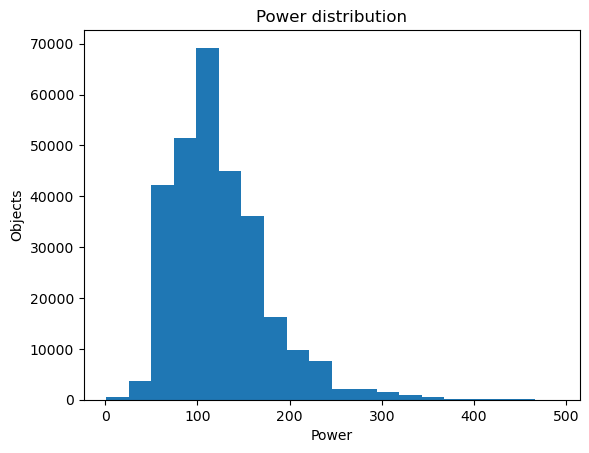

In [18]:
# power distribution
df.query('Power > 0 and Power < 500')['Power'].plot(kind="hist", bins=20, title='Power distribution')
plt.xlabel('Power')
plt.ylabel('Number of objects')
plt.show()

Zero values of `Power` are **~9%** of the dataset left and **~11%** of the original dataset. We don't know the reason why there are so much zeroes in `Power` but that can be a sign that other variables of objects may not be clean. Our goal is to get a clean dataset for modeling, so we'll remove objects with `Power == 0`

In [19]:
# removing zero Power
df = df[df['Power'] != 0].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 289652 entries, 1 to 354368
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   DateCrawled       289652 non-null  datetime64[ns]
 1   Price             289652 non-null  int64         
 2   VehicleType       271292 non-null  object        
 3   RegistrationYear  289652 non-null  int64         
 4   Gearbox           284481 non-null  object        
 5   Power             289652 non-null  int64         
 6   Model             278631 non-null  object        
 7   Kilometer         289652 non-null  int64         
 8   FuelType          272872 non-null  object        
 9   Brand             289652 non-null  object        
 10  Repaired          248803 non-null  object        
 11  DateCreated       289652 non-null  datetime64[ns]
 12  NumberOfPictures  289652 non-null  int64         
 13  PostalCode        289652 non-null  int64         
 14  Last

#### Constant

Column `NumberOfPictures` has constant value

In [20]:
df['NumberOfPictures'].unique()

array([0], dtype=int64)

This column bears no information so we will drop it

In [21]:
df = df.drop(columns=['NumberOfPictures'])
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'FuelType', 'Brand', 'Repaired',
       'DateCreated', 'PostalCode', 'LastSeen'],
      dtype='object')

#### Duplicates

The dataset has some fully duplicated rows so we will drop them

In [22]:
# number duplicates
df.duplicated().sum()

4

In [23]:
# removing duplicates
df = df.drop_duplicates(keep='first')
df.duplicated().sum()

0

#### High cardinality

Columns `DateCrawled`, `DateCreated`, `LastSeen` have no impact on target feature since they are not related to cars themselves but to database operation. We will drop `LastSeen` column.

We won't drop `DateCrawled`, `DateCreated` for now. We will use these columns as a reference to analyse values of `RegistrationYear` column. And then we drop it in cool blood.

In [24]:
df = df.drop(columns=['LastSeen'])
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'FuelType', 'Brand', 'Repaired',
       'DateCreated', 'PostalCode'],
      dtype='object')

#### Column: `RegistrationYear`

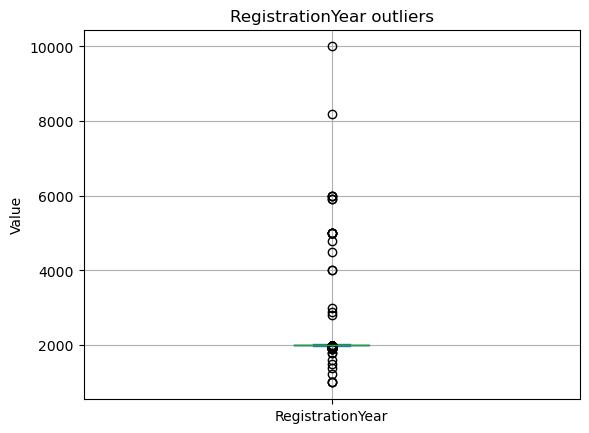

Boxplot values
Q1: 2000.0
Q3: 2008.0
Lower fence: 1988.0
Upper fence 2020.0


In [27]:
%matplotlib inline
df['RegistrationYear'].plot(kind='box', grid=True, title='RegistrationYear outliers')
plt.ylabel('Value')
plt.show()
BoxplotStats(df["RegistrationYear"]).report()

`RegistrationYear` cannot be more than `DateCreated`. And `DateCreated` cannot be more than `DateCrawled`. There are also outliers with the lower fence **1988**. We will leave only objects that meet the condition `1988 <= RegistrationYear <= DateCreated <= DateCrawled`. We remove cars that are too old to be just used

In [28]:
# filter only entries with reasonable year
df = df.query("1988 <= RegistrationYear and \
               RegistrationYear <= DateCreated.dt.year and \
               DateCreated <= DateCrawled").copy()
df.head(3)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,DateCreated,PostalCode
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes,2016-03-24,66954
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,2016-03-14,90480
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,2016-03-17,91074


Now we can remove `DateCreated` and `DateCrawled` from dataset

In [29]:
df = df.drop(columns=["DateCreated", "DateCrawled"])
df.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'Repaired', 'PostalCode'],
      dtype='object')

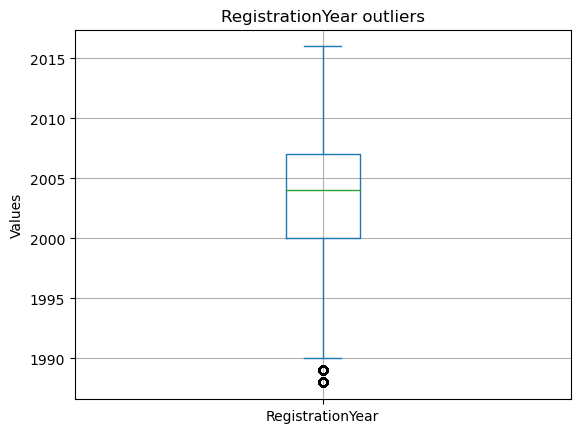

Boxplot values
Q1: 2000.0
Q3: 2007.0
Lower fence: 1989.5
Upper fence 2017.5


In [30]:
%matplotlib inline
# build boxplot again
df['RegistrationYear'].plot(kind='box', grid=True, title='RegistrationYear outliers')
plt.ylabel('Values')
plt.show()
BoxplotStats(df["RegistrationYear"]).report()

#### Column: `Model`

Column `Model` is reported to have high cardinality too but this data could be important for target.

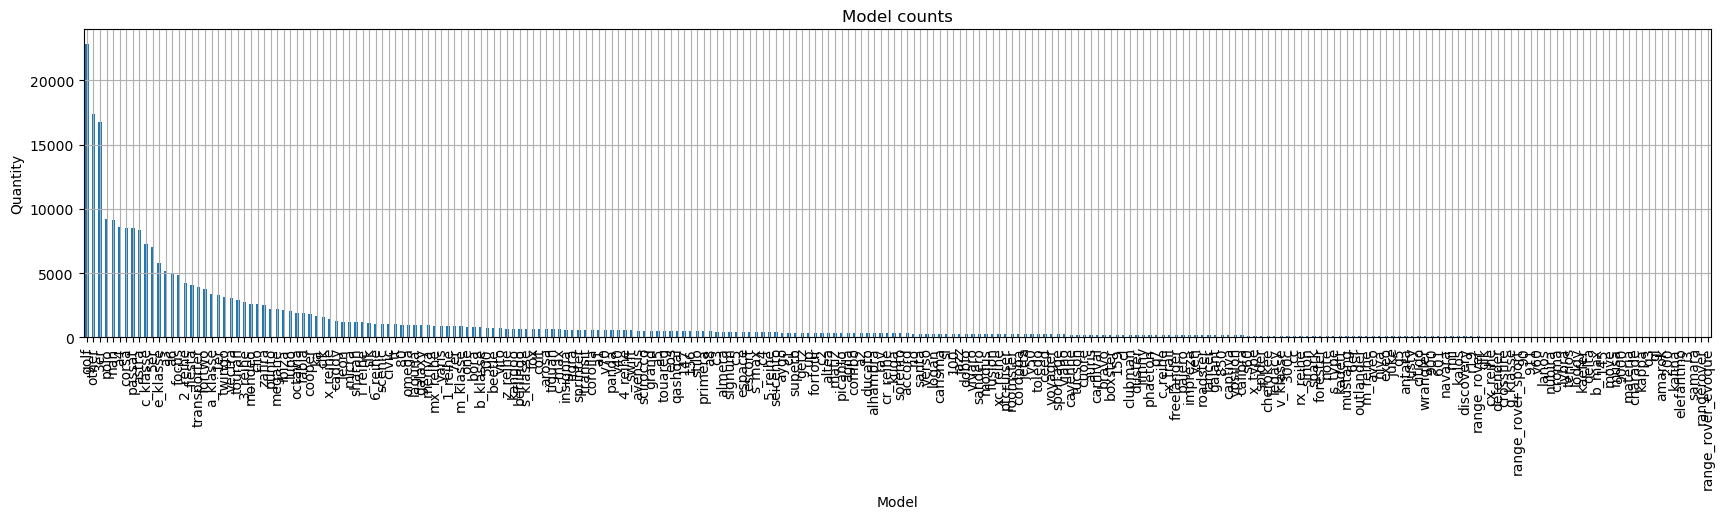

In [32]:
# barplot for models column

model_counts = df['Model'].value_counts(dropna=False)

model_counts.plot(kind="bar", title="Model counts", grid=True, figsize=(21, 4))
plt.xlabel('Model')
plt.ylabel('Number of objects')
plt.show()

In [33]:
# without missing values
model_counts = df['Model'].value_counts()
model_counts

golf                  22822
other                 17382
3er                   16751
polo                   9239
a4                     8581
                      ...  
elefantino                4
i3                        4
samara                    3
rangerover                2
range_rover_evoque        2
Name: Model, Length: 247, dtype: int64

Although `Brand` and `Model` define a car there other features quite differ within one model: same models have different car body type, horsepower etc. Also there are models that are much more popular than others. There are two options:
* Introduce `other` category to models that are not widely present in dataset
* * Note: `other` category is already high in count, having the second place after `golf`
* Remove `Model` feature

We will change 30% least used models to `other`

In [34]:
# drop 'other' from value counts
model_counts = model_counts.drop(index=['other'])
model_counts.head(3)

golf    22822
3er     16751
polo     9239
Name: Model, dtype: int64

In [35]:
# get threshold
model_threshold = model_counts.sum() * 0.7
model_threshold

173852.0

In [36]:
# get popular models list
popular_models = []
cum_sum = 0
for i, v in model_counts.items():  # i - model name, v - quantity
    if cum_sum > model_threshold:
        break
    popular_models.append(i)
    cum_sum += v
print("Number of popular models:", len(popular_models))

Number of popular models: 33


In [37]:
# changing rare models to 'other'
df.loc[~df['Model'].isin(popular_models), 'Model'] = 'other'

In [38]:
df['Model'].value_counts()

other          100827
golf            22822
3er             16751
polo             9239
a4               8581
corsa            8498
passat           8476
astra            8328
c_klasse         7229
5er              7006
e_klasse         5784
a3               5187
a6               4926
focus            4864
2_reihe          4223
fiesta           4075
transporter      3896
fortwo           3785
a_klasse         3361
1er              3281
twingo           3113
vectra           3034
touran           2921
3_reihe          2766
mondeo           2611
clio             2571
zafira           2493
punto            2231
megane           2171
ibiza            2160
lupo             2041
octavia          1911
fabia            1878
cooper           1825
Name: Model, dtype: int64

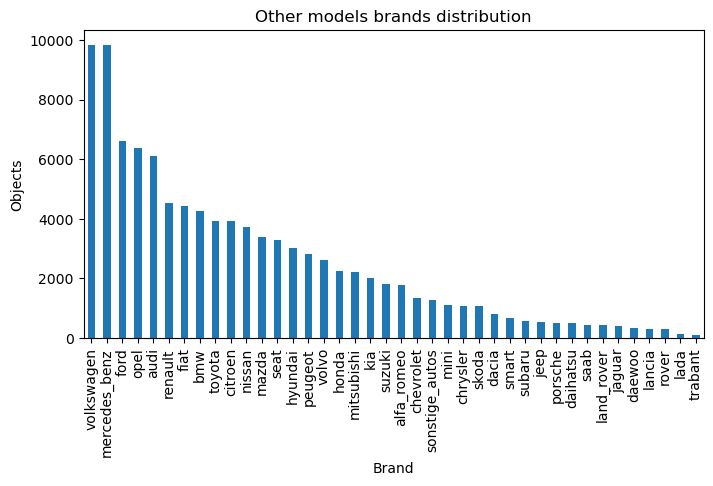

In [43]:
# check brands with 'other' models
df[df['Model'] == 'other']['Brand'].value_counts().plot(kind='bar', figsize=(8, 4), title='Other models brands distribution')
plt.xlabel('Brand')
plt.ylabel('Number of objects')
plt.show()

#### Column: `Power`

Data in this column is reported to be skewed. It has unrealistic values

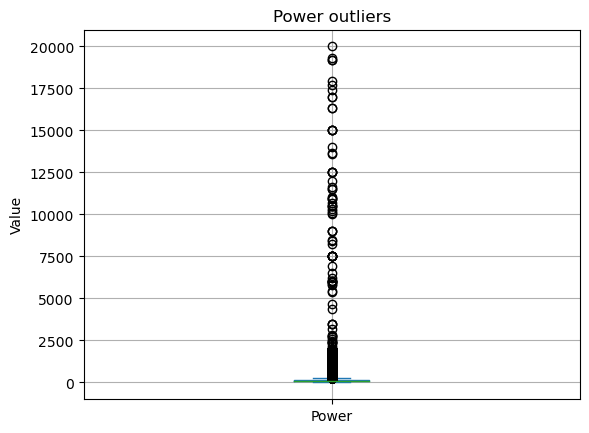

Boxplot values
Q1: 82.0
Q3: 150.0
Lower fence: -20.0
Upper fence 252.0


In [40]:
# build a boxplot
df['Power'].plot(kind='box', grid=True, title='Power outliers')
plt.ylabel('Value')
plt.show()
BoxplotStats(df["Power"]).report()

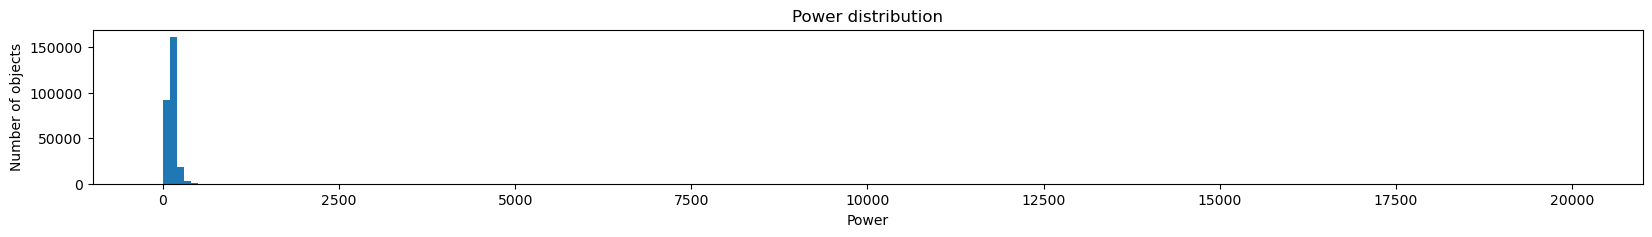

In [44]:
# build a histogram
df["Power"].plot(kind='hist', bins=200, figsize=(20, 2), title='Power distribution')
plt.xlabel('Power')
plt.ylabel('Number of objects')
plt.show()

In [45]:
df['Power'].quantile([0.025, 0.985])

0.025     54.0
0.985    286.0
Name: Power, dtype: float64

We will remove entries with `Power` lower than 50 and higher than upper fence of the edited dataset (286), this will affect less than 5% of entries

In [46]:
# threshold values
low_power = 50
high_power = 286  # upper fence on boxplot
power_threshold = ((df['Power'] < low_power) | (df['Power'] > high_power))
print('Entries to be removed:', power_threshold.sum())
print('Fraction:', power_threshold.sum() / df.shape[0])

Entries to be removed: 6843
Fraction: 0.02489585796663817


In [47]:
# dropping values
df = df[~power_threshold].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268022 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             268022 non-null  int64 
 1   VehicleType       259957 non-null  object
 2   RegistrationYear  268022 non-null  int64 
 3   Gearbox           263940 non-null  object
 4   Power             268022 non-null  int64 
 5   Model             268022 non-null  object
 6   Kilometer         268022 non-null  int64 
 7   FuelType          255992 non-null  object
 8   Brand             268022 non-null  object
 9   Repaired          233222 non-null  object
 10  PostalCode        268022 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 24.5+ MB


#### High correlaion

Having `Price` correlated with `RegistrationYear` and `Power` looks quite natural. Let's take a look on `RegistrationYear` and `VehicleType` columns as it's reported their correlation is full

In [48]:
df['VehicleType'].value_counts(dropna=False)

sedan          76580
small          59644
wagon          56209
bus            25555
convertible    17459
coupe          12351
suv            10130
NaN             8065
other           2029
Name: VehicleType, dtype: int64

In [49]:
# fill missing values
df['VehicleType'] = df['VehicleType'].fillna('other')
df['VehicleType'].value_counts(dropna=False)

sedan          76580
small          59644
wagon          56209
bus            25555
convertible    17459
coupe          12351
suv            10130
other          10094
Name: VehicleType, dtype: int64

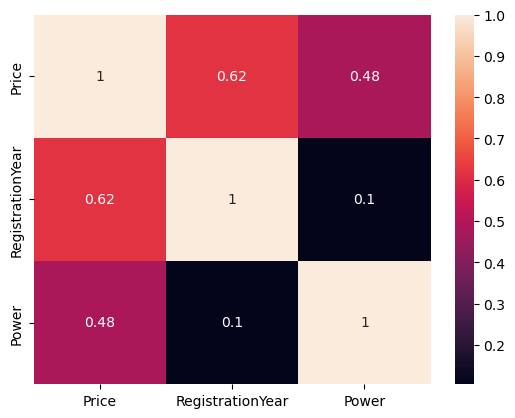

In [50]:
sns.heatmap(df[["Price", "RegistrationYear", "Power"]].corr(), annot=True)
plt.show()

#### Column: `PostalCode`

Despite column `PostalCode` is numeric, it's acually a category with high cardinality of values. We will drop it for now.

**Note:** it might be useful to use [this](https://data.opendatasoft.com/explore/embed/dataset/geonames-postal-code@public/table/) table in order to set regions to different postal codes and use this data as a cat feature

In [51]:
# drop PostalCode column
df = df.drop(columns=['PostalCode'])
df.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'Repaired'],
      dtype='object')

#### Remove high missing values

We have 9 features left. Let's check for entries that have too much missing values simultaniosly

In [52]:
missing_features = df.isna().sum(axis=1)
missing_features.value_counts()

0    223542
1     38635
2      5258
3       587
dtype: int64

We will remove entries that have 3 or more missing values at the same time

In [53]:
stay_condition = missing_features < 3
stay_condition

1         True
2         True
3         True
4         True
5         True
          ... 
354361    True
354362    True
354366    True
354367    True
354368    True
Length: 268022, dtype: bool

In [54]:
df = df[stay_condition].copy()
df.isna().sum(axis=1).value_counts()

0    223542
1     38635
2      5258
dtype: int64

#### Other missing values

We've deleted entries that have 3 or more missing values. Alas, some algorythms still struggle to fit datasets with **NaN** values. Let's set this values to **unknown**

In [55]:
# check missing values
df.isna().sum()

Price                   0
VehicleType             0
RegistrationYear        0
Gearbox              3495
Power                   0
Model                   0
Kilometer               0
FuelType            11443
Brand                   0
Repaired            34213
dtype: int64

We will set missing values for `Gearbox`, `FuelType` and `Repaired` to **unknown**.

In [56]:
# set values to 'unknown'
df[['Gearbox', 'FuelType', 'Repaired']] = df[['Gearbox', 'FuelType', 'Repaired']].fillna('unknown')

### Conclusion

In [57]:
# redo data profiling
profile_final = ProfileReport(df)

In [58]:
profile_final.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

* We still have missing values in `Power` column
* We mostly removed unrealistic and broken data
* Correlation between features rised after data cleaning

In [59]:
# save cleaned data to file
df.reset_index(drop=True).to_csv(PATH_TO_PROCESSED_DATA, index=False)

## Open and split data

Let's open data and split it to train and test samples

In [61]:
# open data from local file
try:
    df = pd.read_csv(PATH_TO_PROCESSED_DATA)
except:
    PATH_TO_PROCESSED_DATA = './datasets/autos_processed.csv'
    df = pd.read_csv(PATH_TO_PROCESSED_DATA)
df.head(3)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,18300,coupe,2011,manual,190,other,125000,gasoline,audi,yes
1,9800,suv,2004,auto,163,other,125000,gasoline,jeep,unknown
2,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no


In [62]:
# categorical features list
cat_features_names = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

# numerical features list
num_features_names = ['RegistrationYear', 'Power', 'Kilometer']

# target feature name
target_feature_name = 'Price'

In [63]:
# define features and target
X = df.drop(columns = [target_feature_name])
y = df[target_feature_name]
print(X.columns)
print(y.name)

Index(['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'Repaired'],
      dtype='object')
Price


We will stratify our split using models feature

In [64]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state = RND,
                                                    stratify=X[['Model']])

for s in [X_train, X_test, y_train, y_test]:
    print(s.shape[0])

200576
66859
200576
66859


## Data transformation

For data preprocessing pipeline we will use:
* standard scaler
* OHE

In [65]:
# column transformation
scaler = StandardScaler()
encoder = OneHotEncoder(drop="first", handle_unknown='ignore', sparse_output=False)

In [66]:
# columns transformer
transformer = ColumnTransformer(
    [
        ("scaler", scaler, num_features_names),
        ("encoder", encoder, cat_features_names)
    ],
    remainder='passthrough'
)

In [67]:
# splitter for cross validation
splitter = StratifiedKFold(n_splits=3, shuffle=True, random_state=RND)

We will put column transformer and iterative inputer into our pipelines.

## Estimator test and report

I will make `EstimatorReport` class. Upon initialisation it will determine RMSE of estimator using `cross_val_score()` then test fit and predict times on provided data

In [83]:
class EstimatorReport():
    """
    Upon initialisation:
    - determines RMSE using cross_val_score
    - measures trainig time on train dataset (to estimate perfomance)
    - measures prediction time on train dataset (to estimate perfomance)
    - score can be explicitly provided for the report in case it was determined earlier
    """
    def __init__(self, estimator, X, y, cv, estimator_name="Unnamed", score=None):
        ER = "[EstimatorReport]:"
        print(ER, "Initialising report:", estimator_name)
        self.name = estimator_name            

        # determine score        
        if not score:
            print(ER, "Evaluating RMSE via cross-validation...")
            self.cvs = cross_val_score(estimator, X, y, scoring="neg_mean_squared_error", cv=cv, n_jobs=-1, verbose=1)
            self.rmse = round((-self.cvs.mean()) ** 0.5)
            print(ER, "Scoring completed!")
        else:
            self.rmse = score
            print(ER, "Score was provided explicitly")
        
        
        # determine train time
        print(ER, "Estimating fitting time...")
        start = time()
        estimator.fit(X, y)
        self.fit_time = time() - start
        print(ER, "Fitting completed!")

        # determine predict time
        print(ER, "Estimating prediction time...")
        start = time()
        estimator.predict(X)
        self.predict_time = time() - start
        print(ER, "Prediction completed!")

        print(ER, "Initialisation completed!")
        
    def report(self):
        return {
            "Model": self.name,
            "RMSE": self.rmse,
            "Fit": round(self.fit_time, 3),
            "Prediction": round(self.predict_time, 3)
        }


## Random Forest Regressor

Let's try random forest regression first. We will build a pipeline that processes features

RandomForestRegressor doesn't fit on data with missing values. Also one fit takes quite a time, so for now I won't use any tools to search for optimal hyperparametrs since our goal is to get RMSE below **2500**

In [69]:
# random forest pipeline
rf_regressor = RandomForestRegressor(n_estimators=400, random_state=RND, verbose=1, n_jobs=-1)

rf_pipeline = Pipeline(
    [
        ("transformer", transformer),
        ("rf_regressor", rf_regressor)
    ],
    verbose=True
)

Now we will fit our pipeline and mesure both fit time and prediction time. Then we will determine RMSE metric

In [70]:
rf_report = EstimatorReport(rf_pipeline, X_train, y_train, splitter, "RandomForestRegressor (400)")

[EstimatorReport]: Initialising report: RandomForestRegressor (400)
[EstimatorReport]: Evaluating RMSE via cross-validation...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
c:\Users\irona\anaconda3\envs\ds4\lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  9.6min finished


[EstimatorReport]: Scoring completed!
[EstimatorReport]: Estimating fitting time...
[Pipeline] ....... (step 1 of 2) Processing transformer, total=   0.7s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  4.8min finished


[Pipeline] ...... (step 2 of 2) Processing rf_regressor, total= 4.8min
[EstimatorReport]: Fitting completed!
[EstimatorReport]: Estimating prediction time...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    5.3s


[EstimatorReport]: Prediction completed!
[EstimatorReport]: Initialisation completed!


[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:   11.5s finished


### Conclusion

In [71]:
rf_report.report()

{'Model': 'RandomForestRegressor (400)',
 'RMSE': 1522,
 'Fit': 290.561,
 'Prediction': 12.187}

Execution time for RandomForest is too high **(~ 5 mins)**, we won't consider this model useful for our case, hence we won't search for optimal hyperparameters

## Linear Regression

Let's use linear regression with the same preprocessing pipeline. I will use `LinearRegression()` with default hyperparameters since there's not so much to tune.

In [72]:
# linear regression pipeline
linreg = LinearRegression(
    n_jobs=-1
)

linreg_pipeline = Pipeline(
    [
        ("transformer", transformer),
        ("linreg:", linreg)
    ],
    verbose=2
)

In [84]:
linreg_report = EstimatorReport(linreg_pipeline, X_train, y_train, splitter, "Linear Regression")

[EstimatorReport]: Initialising report: Linear Regression
[EstimatorReport]: Evaluating RMSE via cross-validation...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
c:\Users\irona\anaconda3\envs\ds4\lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.6s finished
c:\Users\irona\anaconda3\envs\ds4\lib\site-packages\sklearn\utils\_param_validation.py:591: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


[EstimatorReport]: Scoring completed!
[EstimatorReport]: Estimating fitting time...
[Pipeline] ....... (step 1 of 2) Processing transformer, total=   0.6s
[Pipeline] ........... (step 2 of 2) Processing linreg:, total=   0.9s
[EstimatorReport]: Fitting completed!
[EstimatorReport]: Estimating prediction time...
[EstimatorReport]: Prediction completed!
[EstimatorReport]: Initialisation completed!


### Conclusion

In [85]:
d_print(linreg_report.report())

Model: Linear Regression
RMSE: 2360
Fit: 1.464
Prediction: 0.576


The model fits quite fast. The RMSE score fits or requirements

## Light GBM

LightGBM is a gradient boosting model designed to work fast with big datasets.
* We will use LightGBM regressor.
* We will use Optuna to tune hyperparameters. LightGBM is fast, so we can try less values for the learning rate.
* We will tune our estimator and then test it

In order to use LGBM with automatic categorical features handling, we need to turn pandas DataFrame into LGBM Dataset. We also have to scale numerical data beforehand

In [75]:
# light gbm for tuning
lgb_regressor = LGBMRegressor(
        n_jobs=-1,
        random_state=RND
)

lgb_pipeline = Pipeline(
    [
        ("transformer", transformer),
        ("lgb", lgb_regressor)
    ]
)

In [76]:
lgb_param_grid = {
    "lgb__num_leaves": IntDistribution(10, 50),
    "lgb__max_depth": IntDistribution(0, 25),
    "lgb__learning_rate": FloatDistribution(0.01, 0.2),
    "lgb__n_estimators": IntDistribution(100, 800)
}

In [77]:
# setting optuna search
lgb_optuna = OptunaSearchCV(
    estimator=lgb_pipeline,
    param_distributions=lgb_param_grid,
    cv=5,
    n_jobs=-1,
    n_trials=30,
    scoring="neg_root_mean_squared_error",
    random_state=RND,
    verbose=1
)

C:\Users\irona\AppData\Local\Temp\ipykernel_27940\1395200231.py:2: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  lgb_optuna = OptunaSearchCV(


In [78]:
lgb_optuna.fit(X_train, y_train)

[I 2023-09-12 03:21:15,650] A new study created in memory with name: no-name-db1f381c-fcc3-4bdd-9b4c-f017d1e74662
[I 2023-09-12 03:21:15,651] Searching the best hyperparameters using 200576 samples...


c:\Users\irona\anaconda3\envs\ds4\lib\site-packages\sklearn\preprocessing\_encoders.py:227: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\irona\anaconda3\envs\ds4\lib\site-packages\sklearn\preprocessing\_encoders.py:227: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\irona\anaconda3\envs\ds4\lib\site-packages\sklearn\preprocessing\_encoders.py:227: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[I 2023-09-12 03:21:53,095] Trial 1 finished with value: -1697.5455893357025 and parameters: {'lgb__num_leaves': 10, 'lgb__max_depth': 2, 'lgb__learning_rate': 0.1364620329875496, 'lgb__n_estimators': 479}. Best is trial 1 with value: -1697.5455893357025.
[I 2023-09-12 03:21:57,089] Trial 0 finish

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 451
[LightGBM] [Info] Number of data points in the train set: 200576, number of used features: 92
[LightGBM] [Info] Start training from score 5067.490886


[I 2023-09-12 03:28:15,241] Finished refitting! (elapsed time: 4.713 sec.)


OptunaSearchCV(cv=5,
               estimator=Pipeline(steps=[('transformer',
                                          ColumnTransformer(remainder='passthrough',
                                                            transformers=[('scaler',
                                                                           StandardScaler(),
                                                                           ['RegistrationYear',
                                                                            'Power',
                                                                            'Kilometer']),
                                                                          ('encoder',
                                                                           OneHotEncoder(drop='first',
                                                                                         handle_unknown='ignore',
                                                                                         sparse_output=False),
                                                                           ['VehicleType',
                                                                            'Gearbox',
                                                                            'Model',
                                                                            'FuelType',
                                                                            'Brand',
                                                                            'Repaired'])])),
                                         ('lgb',
                                          LGBMRe...
               param_distributions={'lgb__learning_rate': FloatDistribution(high=0.2, log=False, low=0.01, step=None),
                                    'lgb__max_depth': IntDistribution(high=25, log=False, low=0, step=1),
                                    'lgb__n_estimators': IntDistribution(high=800, log=False, low=100, step=1),
                                    'lgb__num_leaves': IntDistribution(high=50, log=False, low=10, step=1)},
               random_state=1337, scoring='neg_root_mean_squared_error',
               verbose=1)

In [88]:
lgb_report = EstimatorReport(lgb_optuna.best_estimator_, X_train, y_train, splitter, "LightGBM Regressor", score=-round(lgb_optuna.best_score_))

[EstimatorReport]: Initialising report: LightGBM Regressor
[EstimatorReport]: Score was provided explicitly
[EstimatorReport]: Estimating fitting time...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 451
[LightGBM] [Info] Number of data points in the train set: 200576, number of used features: 92
[LightGBM] [Info] Start training from score 5067.490886
[EstimatorReport]: Fitting completed!
[EstimatorReport]: Estimating prediction time...
[EstimatorReport]: Prediction completed!
[EstimatorReport]: Initialisation completed!


### Conclusion

In [89]:
d_print(lgb_report.report())

Model: LightGBM Regressor
RMSE: 1436
Fit: 4.68
Prediction: 2.097


This tuned solution offers less RMSE but in the cost of longer fitting and prediction time

## CatBoost (default)

CatBoost can handle categorical parameters on its own and you don't have to transform dataset to some other forms. We can use the same `param_distributions` for Optuna. Also, unlike LightGBM, you don't have to rebuild the library from code in order to use GPU in CatBoost. We try CatBoost with default settings first

In [90]:
# catboost regressor and pipeline

cb_default = CatBoostRegressor(
    task_type='GPU',
    verbose=False,
    cat_features=cat_features_names,
    random_state=RND
)

In [91]:
cb_default_report = EstimatorReport(cb_default, X_train, y_train, splitter, "CatBoost (default)")

[EstimatorReport]: Initialising report: CatBoost (default)
[EstimatorReport]: Evaluating RMSE via cross-validation...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
c:\Users\irona\anaconda3\envs\ds4\lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 11.3min finished


[EstimatorReport]: Scoring completed!
[EstimatorReport]: Estimating fitting time...
[EstimatorReport]: Fitting completed!
[EstimatorReport]: Estimating prediction time...
[EstimatorReport]: Prediction completed!
[EstimatorReport]: Initialisation completed!


### Conclusion

In [128]:
d_print(cb_default_report.report())

Model: CatBoost (default)
RMSE: 1516
Fit: 77.355
Prediction: 1.162


## Final conclusion

In [129]:
# let's combine all reports and determine ranks
conclusion = pd.DataFrame(
    [
        linreg_report.report(),
        rf_report.report(),
        lgb_report.report(),
        cb_default_report.report(),
    ]
)

for col in ['RMSE', 'Fit', 'Prediction']:
    conclusion[col+' rank'] = conclusion[col].rank()


In [132]:
# display tables
print('Final table')
display(conclusion)

# sorted views but with removed dummies
for col in ['RMSE rank', 'Fit rank', 'Prediction rank']:
    print(col+' (sorted by rank)')
    display(conclusion.sort_values(by=col))


Final table


,Model,RMSE,Fit,Prediction,RMSE rank,Fit rank,Prediction rank
0,Linear Regression,2360,1.464,0.576,4.0,1.0,1.0
1,RandomForestRegressor (400),1522,290.561,12.187,3.0,4.0,4.0
2,LightGBM Regressor,1436,4.680,2.097,1.0,2.0,3.0
3,CatBoost (default),1516,77.355,1.162,2.0,3.0,2.0


RMSE rank (sorted by rank)


,Model,RMSE,Fit,Prediction,RMSE rank,Fit rank,Prediction rank
2,LightGBM Regressor,1436,4.680,2.097,1.0,2.0,3.0
3,CatBoost (default),1516,77.355,1.162,2.0,3.0,2.0
1,RandomForestRegressor (400),1522,290.561,12.187,3.0,4.0,4.0
0,Linear Regression,2360,1.464,0.576,4.0,1.0,1.0


Fit rank (sorted by rank)


,Model,RMSE,Fit,Prediction,RMSE rank,Fit rank,Prediction rank
0,Linear Regression,2360,1.464,0.576,4.0,1.0,1.0
2,LightGBM Regressor,1436,4.680,2.097,1.0,2.0,3.0
3,CatBoost (default),1516,77.355,1.162,2.0,3.0,2.0
1,RandomForestRegressor (400),1522,290.561,12.187,3.0,4.0,4.0


Prediction rank (sorted by rank)


,Model,RMSE,Fit,Prediction,RMSE rank,Fit rank,Prediction rank
0,Linear Regression,2360,1.464,0.576,4.0,1.0,1.0
3,CatBoost (default),1516,77.355,1.162,2.0,3.0,2.0
2,LightGBM Regressor,1436,4.680,2.097,1.0,2.0,3.0
1,RandomForestRegressor (400),1522,290.561,12.187,3.0,4.0,4.0


* Dataset has a lot of outliers and missing values.
* * I marked outliers as **NaN** values and removed only objects with 3 or more missing values.
* * For objects left I changed **NaN**s to **unknown** values in categorical features.
* All models except dummies showed RMSE score that meets reqirements.
* Random Forest Regressor showed itself to be the slowest one.
* Linear Regression was the fastest to fit and to predict. It has the worst RMSE score but it still fits requirements.
* CatBoost fits much slower than LGBM but makes predictions faster.
* LGBM fit time is the second after Linear Regression

We will choose LightGBM as our model. Let's test its score on test data.

In [122]:
lgb_pred = lgb_optuna.best_estimator_.predict(X_test)

In [123]:
mean_squared_error(y_test, lgb_pred, squared=False)

1429.1580810341868

### Compare to dummy models

We will compare our score to different dummy strategies

In [138]:
# fill mean values
dummy_mean = DummyRegressor(strategy='mean')

dummy_mean_pipeline = Pipeline(
    [
        ("transformer", transformer),
        ("dummy", dummy_mean)
    ]
)

In [139]:
# fill median values
dummy_median = DummyRegressor(strategy='median')

dummy_median_pipeline = Pipeline(
    [
        ("transformer", transformer),
        ("dummy", dummy_median)
    ]
)

In [140]:
dummy_mean_pipeline.fit(X_train, y_train)
dummy_mean_report = {
    'Model': "Mean dummy values",
    'RMSE': round(
        mean_squared_error(
            y_test, dummy_mean_pipeline.predict(X_test), squared=False
            ) # type: ignore
        ),
}

In [141]:
dummy_median_pipeline.fit(X_train, y_train)
dummy_median_report = {
    'Model': "Median dummy values",
    'RMSE': round(
        mean_squared_error(
            y_test, dummy_median_pipeline.predict(X_test), squared=False
            ) # type: ignore
        ),
}

In [143]:
for d in [dummy_mean_report, dummy_median_report]:
    d_print(d)

Model: Mean dummy values
RMSE: 4543
Model: Median dummy values
RMSE: 4811


Final score for LGBM is **1442**. This is more than **3 times** better compared to the score of constant models